<a href="https://colab.research.google.com/github/Pariasjulian/IA/blob/main/1_Corte/P_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries






In [ ]:
#-------------------------------------------------------------------------------
!pip install tf-keras-vis tensorflow
#-------------------------------------------------------------------------------

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from sklearn.model_selection import ShuffleSplit
from tensorflow import keras
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# CAMS math

GradCAM is another way of visualizing attention over input. Instead of using gradients of model outputs, it uses of penultimate layer output (that is the convolutional layer just before Dense layers).

**Gradient-weighted Class Activation Mapping**. In order to obtain the class-discriminative localization map GradCAM $$L^c_{Grad-Cam}\in\mathbb{R}^{u\times v}$$
In general architectures, we first compute the gradient of $y^c$ with respect to feature maps $A$ of a convolutional layer, i.e. $\frac{\partial y^c}{\partial A^k_{ij}}$. These gradients flowing
back are global-average-pooled to obtain weights $\alpha^c_k$: $$\alpha^c_k=\frac{1}{Z}\sum_i\sum_j \frac{\partial y^c}{\partial A^k_{ij}}$$

 - $y^c\rightarrow$ score for each class $c$
 - This weight $\alpha^c_k$ represents a partial linearization of the deep network downstream from $A$, and captures the *importance* of feature map $k$ for a target class $c$.

Empirically, using the averaged gradient through Global Average Pooling (GAP) **is more robust to noise in the gradients and thus leads to better localizations** than other choices like taking the Global Max Pooling, as shown in the supplementary.

In general, $y^c$ need not be the class score produced by an image classification CNN, and could be any differentiable activation. As in CAM, our Grad-CAM heat-map is a weighted combination of feature maps, but we follow this by a ReLU: $$L^c_{Grad-Cam}=ReLU\left(\sum_k\alpha^c_kA^k\right)$$

* The motivation for the ReLU is the following – we are only interested in the features that have a positive influence on the class of interest, i.e. pixels whose intensity should be increased in order to increase $y^c$. Since the feature maps $A$ are already non-negative, we rectify the heat-map obtained to highlight such pixel.


## GradCam implementation per trial

## GradCAM++

GradCAM++ can provide better visual explanations of CNN model predictions.

the final classification score $Y^c$ for a particular class $c$ can be written as a linear combination of its global average pooled last convolutional layer feature maps $A^k$

$$Y^c= \sum_k w_k^c \sum_i \sum_j A_{ij}^k$$

Each spatial location $(i,j)$ in the class-specific saliency map $L_c$ is then calculated as:
$$L_{i,j}^c= \sum_k w_k^cA_{ij}^k$$
$L_{ij}^c$ directly correlates with the importance of a particular spatial location $(i,j)$ for a particular class $c$ and thus functions as a visual explanation of the class predicted by the network. CAM estimates these weights $w_k^c$ by training a linear classifier for each class c using the activations maps of the last convolutional layer generated for a given image.
This hoever limits its explainability prowess to CNNs with a GAP penultimate layer, and requires retraining of multiple linear classifiers (one for each class), after training of the initial model.

Grad-CAM was built to address these issues. This approach define weights $w_k^c$ for a particular feature map $A^k$ and class $c$ as:
$$w_k^c=\frac{1}{Z}\sum_i \sum_j \frac{\partial Y^c}{\partial A_{ij}^k} $$

Consider a saliency map $L^c$ (where $i$ and $j$ are the iterators over the pixels in the map). $A^k$ represents the visualization of the $k^{th}$ feature map. The derivate $\frac{\partial y^c}{\partial A_{ij}^k}$ is expected to be high for the feature map pixels that contribute to the presence of the object. Without loss of generality, let us asume the derivative map to be:

$$\frac{\partial y^c}{\partial A_{ij}^k}=1 \;\;\; if \;\;\; A_{ij}^k=1$$
$$\frac{\partial y^c}{\partial A_{ij}^k}=0 \;\;\; if \;\;\; A_{ij}^k=0$$

different feature maps may be activated with difering spatial footprints, and the feature maps with lesser footprints fade away in the final seliency map

This problem can be fixed by taking a weighted average of the pixel-wise gradients. In particular, we reformulate the structure of the weights $w_k^c$
$$w_k^c=\sum_i \sum_j \alpha_{ij}^{kc}relu\left (\frac{\partial Y^c}{\partial A_{ij}^k} \right)$$
where $relu$ is the rectified linear unit activation function. Here the $\alpha_{ij}^{kc}$ are the weighting co-efficients for the pixel-wise gradients for class c and convolutional feature map $A^k$. In the above example, by taking

$$\alpha_{ij}^{kc}= \frac{1}{\sum_{l,m}\frac{\partial Y^c}{\partial A_{lm}^k} }\;\;\; if \;\;\;\frac{\partial Y^c}{\partial A_{ij}^k}=1$$
$$= 0 \;\;\;  otherwise$$

## Saliency maps

`Saliency` generates a saliency map that appears the regions of ​​the input image that contributes the most to the output value.

Los mapas sobresalientes para una imagen dada, $L^c$ son calculados como una combinacion lineal de los mapas de activacion, seguida por una capa relu:

$$L_{ij}^c = relu \left(\sum_k w_k^c A_{ij}^k \right)$$

Similar a Grad-CAM,

## ScoreCAM

Given a CNN model $Y = f(X)$ that takes an input $X$ and outputs a scalar $Y$. We pick an internal convolutional layer $l$ in $f$ and the corresponding activation as $A$. Denote the $k-th$ channel of $A_l$ by $A_l^k$ towards. For a known baseline input $X_b$, the contribution $A_l^k$ towards $Y$ is defined as
$$C(A_l^k)=f(X\circ H_l^k)-f(X_b)$$
where
$$H_l^k = s(Up(A_l^k))$$
$Up(\cdot)$ denotes the operation that upsamples $A_l^k$ into the input size and $s(\cdot)$ is a normalization function that maps each element in the input matrix into $[0,1]$

- Use of Upsampling

# Dataset

In [ ]:
#cargar fashion mnist o mnist
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
#(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_valid = X_train[:-55000], X_train[-55000:]
y_train, y_valid = y_train[:-55000], y_train[-55000:]

X_train = X_train[..., np.newaxis]/255.
X_valid = X_valid[..., np.newaxis]/255.
X_test = X_test[..., np.newaxis]/255.
print(X_train.shape,X_valid.shape,X_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(5000, 28, 28, 1) (55000, 28, 28, 1) (10000, 28, 28, 1)


# Training Deep CNN model

In [ ]:
from functools import partial
tf.keras.backend.clear_session()

DefaultConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

tf.keras.backend.clear_session()
inputA= tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]), name='input')
tmp = tf.keras.layers.BatchNormalization()(inputA)
tmp = DefaultConv2D(filters=16, kernel_size=7,name='cnn_0')(inputA)
tmp = tf.keras.layers.BatchNormalization()(tmp)
tmp = tf.keras.layers.MaxPooling2D(pool_size=2)(tmp)
tmp = tf.keras.layers.BatchNormalization()(tmp)
tmp = DefaultConv2D(filters=32, kernel_size=3,name='cnn_1')(tmp)
tmp = tf.keras.layers.BatchNormalization()(tmp)
tmp = tf.keras.layers.MaxPooling2D(pool_size=2)(tmp)
tmp = tf.keras.layers.BatchNormalization()(tmp)
tmp = DefaultConv2D(filters=32, kernel_size=3,name='cnn_2')(tmp)
tmp = tf.keras.layers.BatchNormalization()(tmp)

tmp = tf.keras.layers.Flatten()(tmp)
tmp = tf.keras.layers.Dense(units=64, activation='relu',name='dense_0')(tmp)
tmp = tf.keras.layers.BatchNormalization()(tmp)
tmp = tf.keras.layers.Dropout(0.25)(tmp) # regularizar, apagar aleatoriamente neuronas
tmp = tf.keras.layers.Dense(units=32, activation='relu',name='dense_1')(tmp)
tmp = tf.keras.layers.BatchNormalization()(tmp)
tmp = tf.keras.layers.Dropout(0.25)(tmp)
output = tf.keras.layers.Dense(units=10, activation='softmax')(tmp)

#built model
model = tf.keras.Model(inputs=[inputA],outputs=[output])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cnn_0 (Conv2D)                       │ (None, 28, 28, 16)          │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cnn_1 (Conv2D)                       │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cnn_2 (Conv2D)                       │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 7, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_0 (Dense)                      │ (None, 64)                  │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │              

 Total params: 118,410 (462.54 KB)

 Trainable params: 117,962 (460.79 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
#training
model.compile(loss="crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid),batch_size=128)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 190ms/step - accuracy: 0.5814 - loss: 1.2784 - val_accuracy: 0.3103 - val_loss: 2.0864
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7804 - loss: 0.6294 - val_accuracy: 0.1658 - val_loss: 2.8585
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8193 - loss: 0.5097 - val_accuracy: 0.1079 - val_loss: 3.1453
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8488 - loss: 0.4330 - val_accuracy: 0.4424 - val_loss: 1.5496
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8570 - loss: 0.3926 - val_accuracy: 0.6599 - val_loss: 0.9584
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8804 - loss: 0.3294 - val_accuracy: 0.6307 - val_loss: 0.9859
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8886 - loss: 0.3172 - val_accuracy: 0.7921 - val_loss: 0.6425
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8990 - loss: 0.2923 - val_accuracy: 0.8165 -

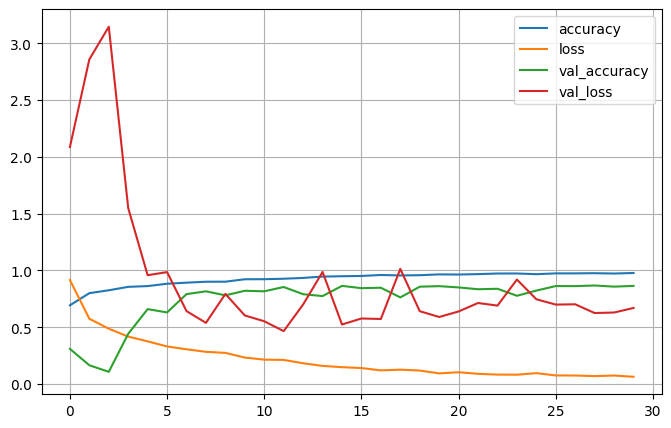

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [ ]:
score   = model.evaluate(X_test, y_test)
print(score)
X_new   = X_test[:5] # pretend we have new images
y_pred  = model.predict(X_new)
print(y_pred.round(2),y_test[:5])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8576 - loss: 0.7254
[0.7117665410041809, 0.8607000112533569]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]] [9 2 1 1 6]


# Feature maps

In [ ]:
def plot_featureMaps(X,model,layer_name,n_rows=4,n_cols=4):
    model_B = tf.keras.Model(inputs=model.inputs,outputs=model.get_layer(layer_name).output) #se accede a capas por nombre
    #tf.keras.utils.plot_model(model_B) # modleo ya esta ajustado!
    z = model_B.predict(X)
    print('Shape',z.shape)
    plt.figure(figsize=(3,3))
    if X.shape[-1]==1:
        plt.imshow(X[0,:,:,0], cmap="binary", interpolation="nearest")
    else:
        plt.imshow(X[0])
    tit=str(model.predict(X).round(2))
    plt.title(tit)
    plt.axis('off')
    plt.show()

    f, ax = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(6,6))
    index = 0
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            pb = ax[row,col].imshow(z[0,:,:,index], cmap="jet", interpolation="nearest",vmin=z.min(),vmax=z.max())
            ax[row,col].axis('off')
            ax[row,col].set_title("f_m" + str(index+1), fontsize=12)

    plt.tight_layout()
    cbar_ax = f.add_axes([1.01, 0, 0.025, 0.95])
    f.colorbar(pb,shrink=0.25, cax=cbar_ax)
    #save_fig('fashion_mnist_plot', tight_layout=False)
    plt.show()
    return

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Shape (1, 28, 28, 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


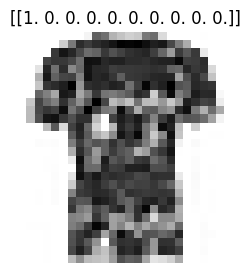

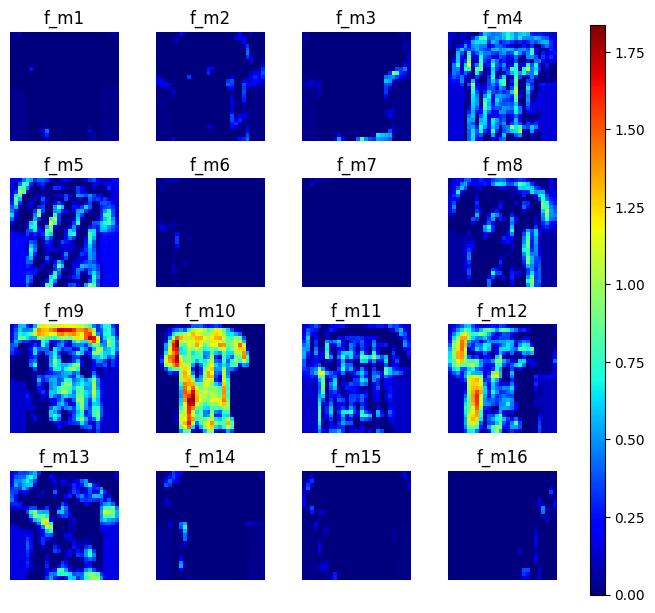

In [ ]:
#plot feature maps
plot_featureMaps(X_test[400][np.newaxis,...],model,layer_name='cnn_0',n_rows=4,n_cols=4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Shape (1, 14, 14, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


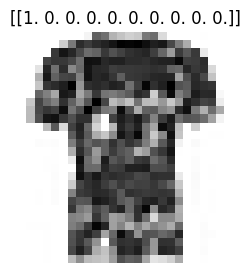

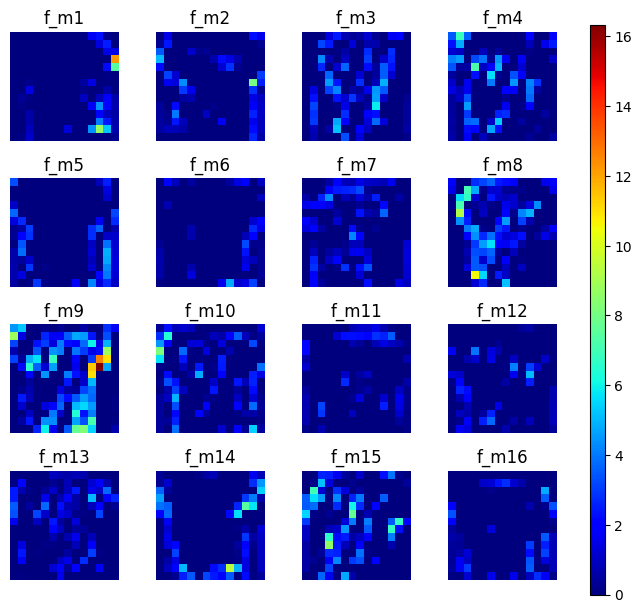

In [ ]:
#plot feature maps
plot_featureMaps(X_test[400][np.newaxis,...],model,layer_name='cnn_1',n_rows=4,n_cols=4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
Shape (1, 7, 7, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


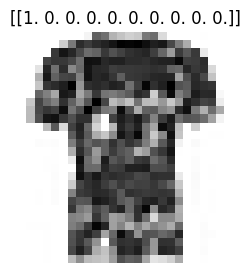

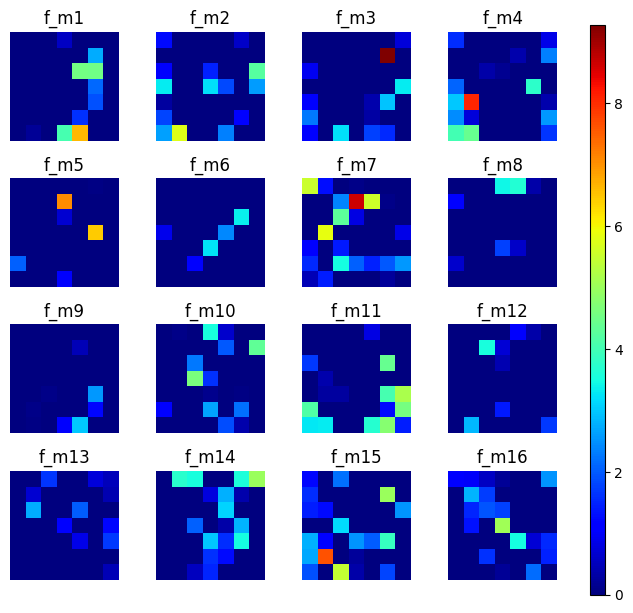

In [ ]:
#plot feature maps
plot_featureMaps(X_test[400][np.newaxis,...],model,layer_name='cnn_2',n_rows=4,n_cols=4)

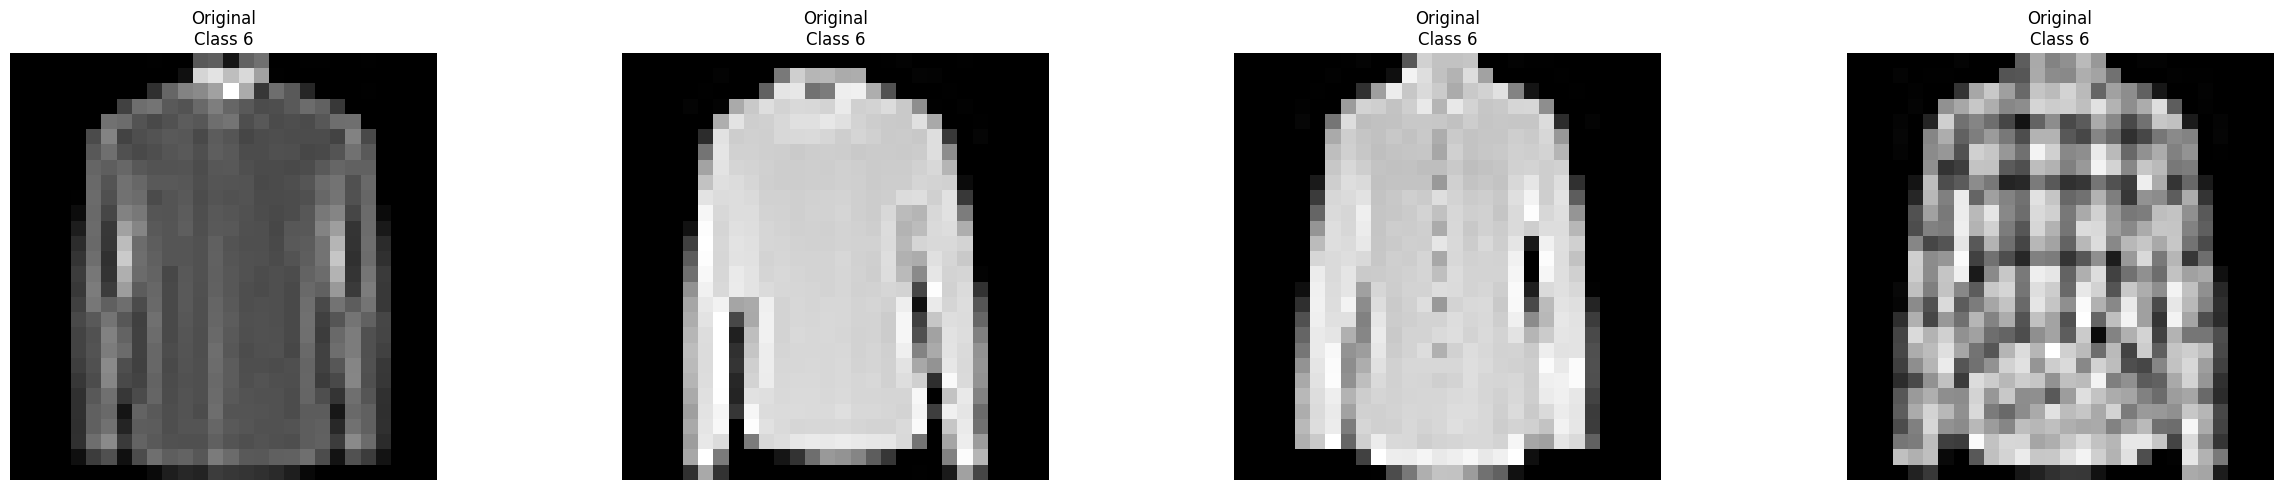

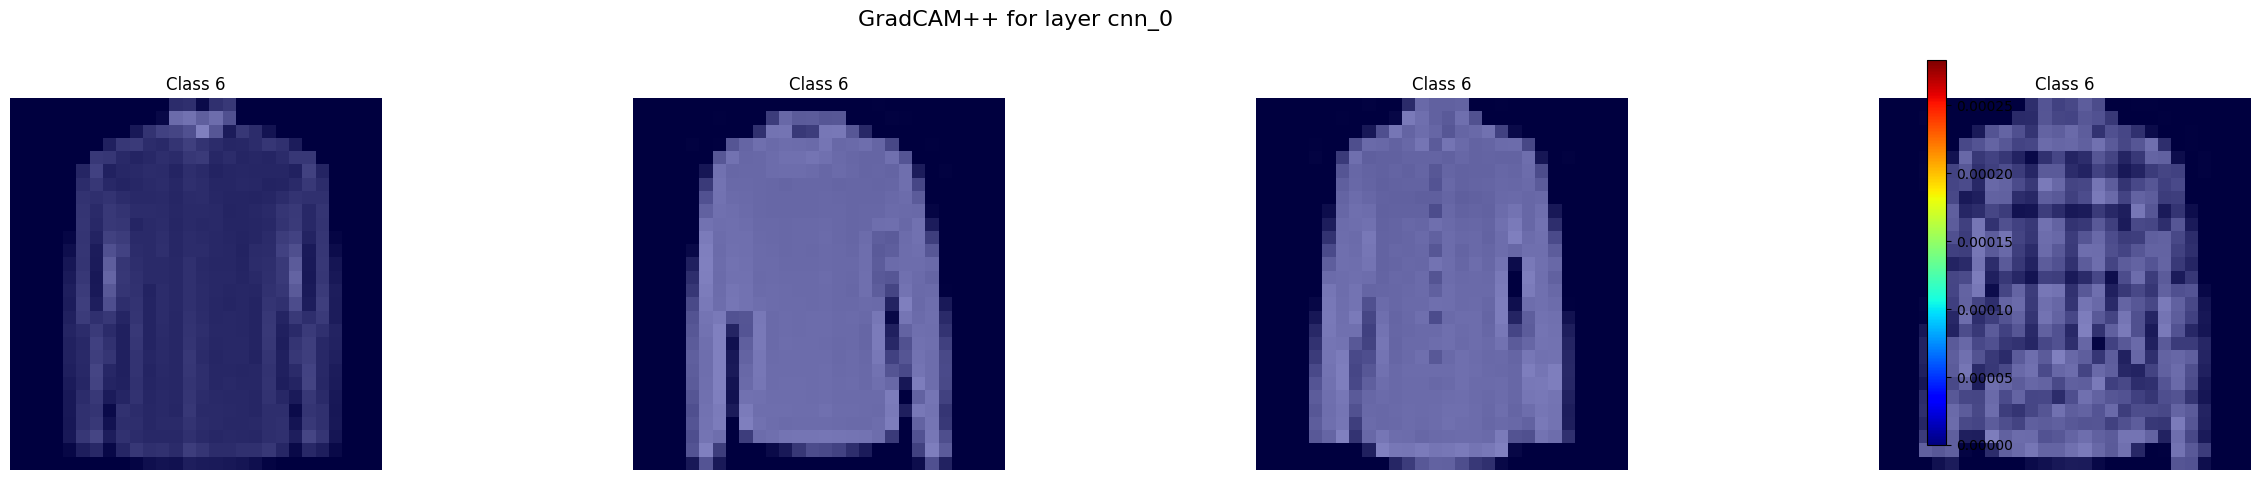

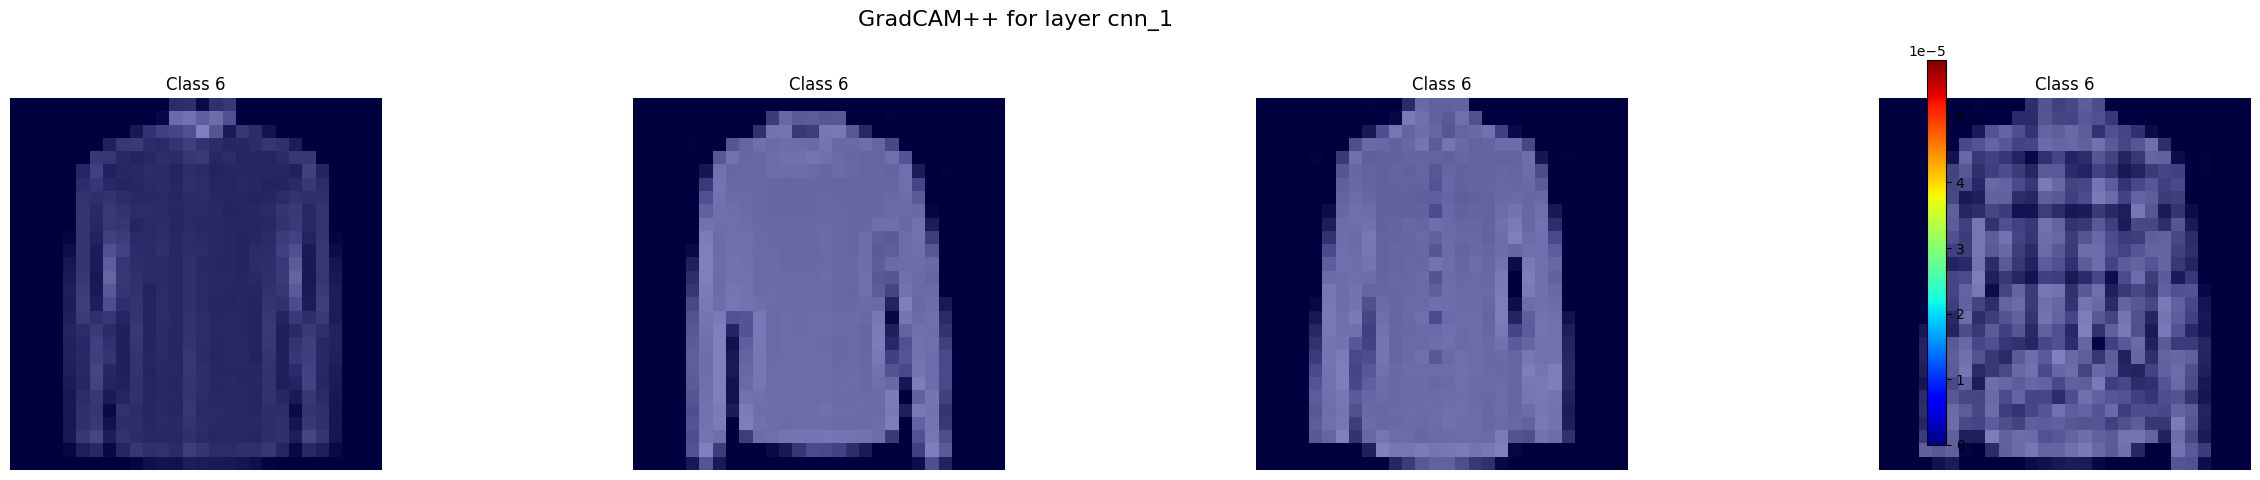

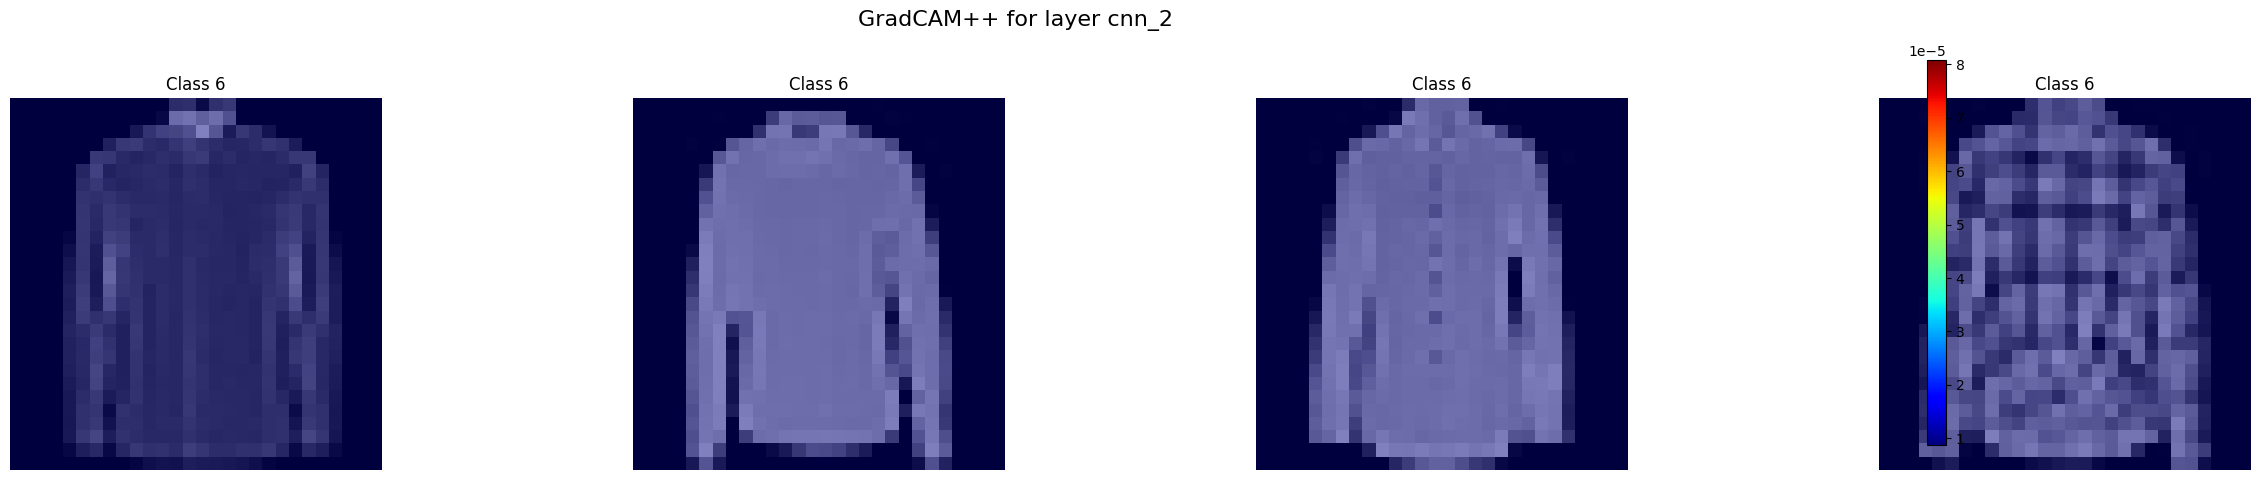

In [ ]:
# List of layers to visualize using GradCAM++
layers = ['cnn_0', 'cnn_1', 'cnn_2']

# Select the first 4 images from the test set
num_images = 4
class_label = 6
class_indices = np.where(y_test == class_label)[0]
random_indices = np.random.choice(class_indices, num_images, replace=False)
images = X_test[random_indices].reshape(-1, 28, 28, 1)
labels = y_test[random_indices]


# Visualize the original images
fig, axes = plt.subplots(1, num_images, figsize=(25, 5))
for ax_img, image, label in zip(axes, images, labels):
    ax_img.imshow(image.squeeze(), cmap='gray')
    ax_img.axis('off')
    ax_img.set_title(f'Original\nClass {label}')  # Replace 'label' with actual class label if available
plt.tight_layout()
plt.show()

# Create a model with the classifier output layer
model_for_gradcam = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('dense').output)

# Initialize GradCAM++ object
gradcam = GradcamPlusPlus(model_for_gradcam, model_modifier=ReplaceToLinear(), clone=True)

# Iterate over each layer for GradCAM++ visualization
for layer in layers:
    # Generate GradCAM++ heatmaps and visualize them
    fig, axes = plt.subplots(1, num_images, figsize=(25, 5))
    fig.suptitle(f'GradCAM++ for layer {layer}', fontsize=16)  # Add title with layer name

    for ax_heatmap, image, label in zip(axes, images, labels):
        # Generate the CAM using GradCAM++ for the specified layer
        cam = gradcam(CategoricalScore(1), image.reshape(1, 28, 28, 1), penultimate_layer=layer, normalize_cam=False)

        # Convert the CAM to a heatmap and plot it over the original image
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
        ax_heatmap.imshow(image.squeeze(), cmap='gray')
        ax_heatmap.imshow(heatmap, cmap='jet', alpha=0.5)
        ax_heatmap.axis('off')
        ax_heatmap.set_title(f'Class {label}')

    # Add a single color bar to the figure
    norm = plt.Normalize(vmin=cam[0].min(), vmax=cam[0].max())
    sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=axes, orientation="vertical", fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


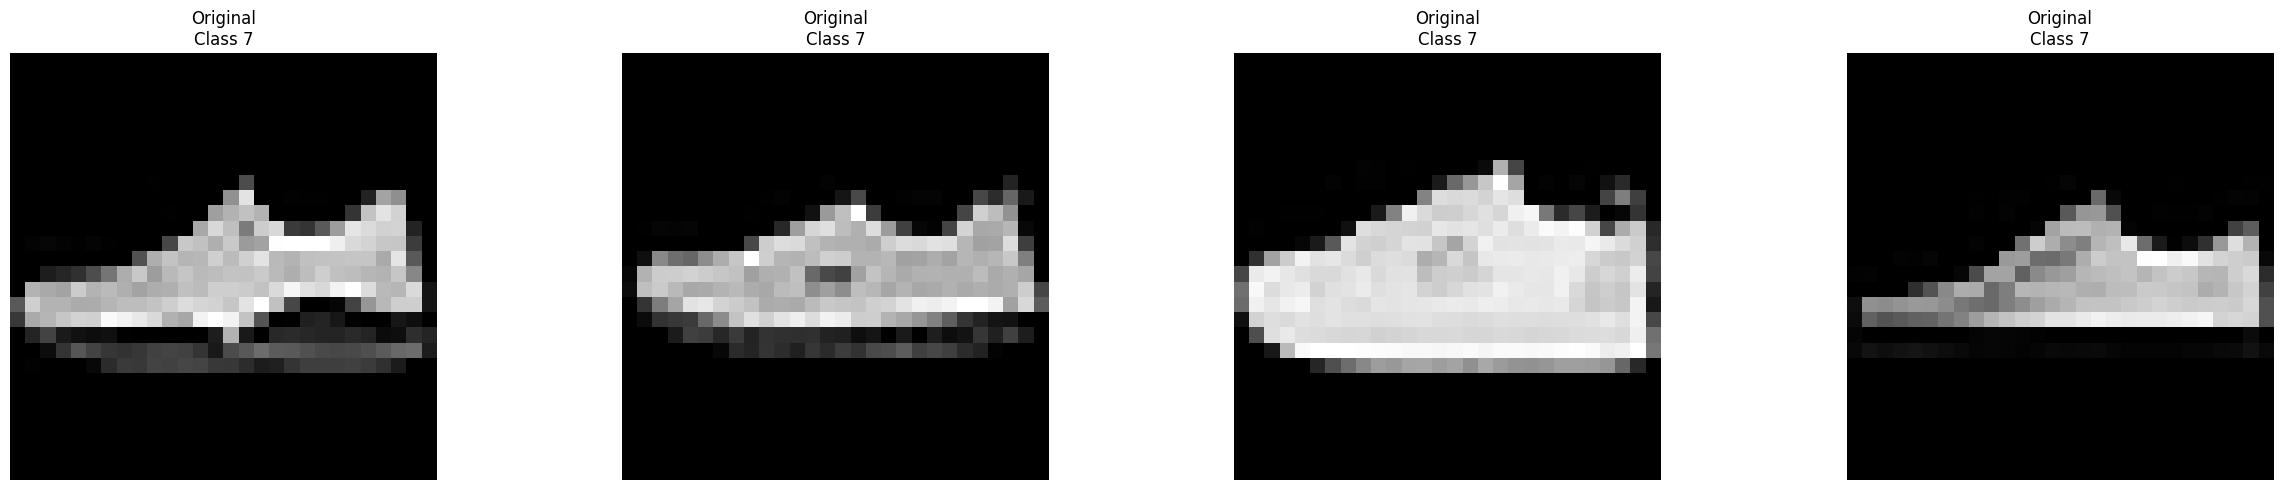

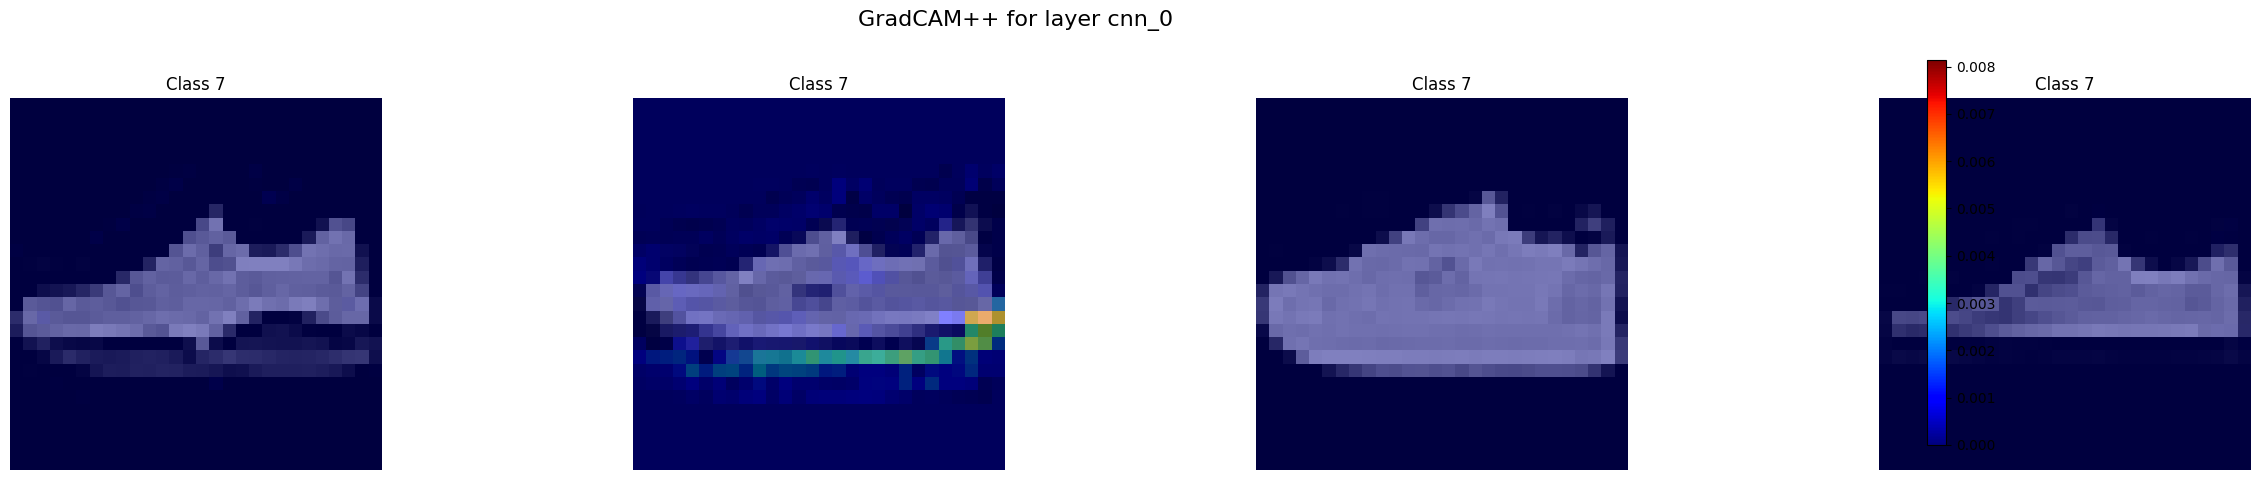

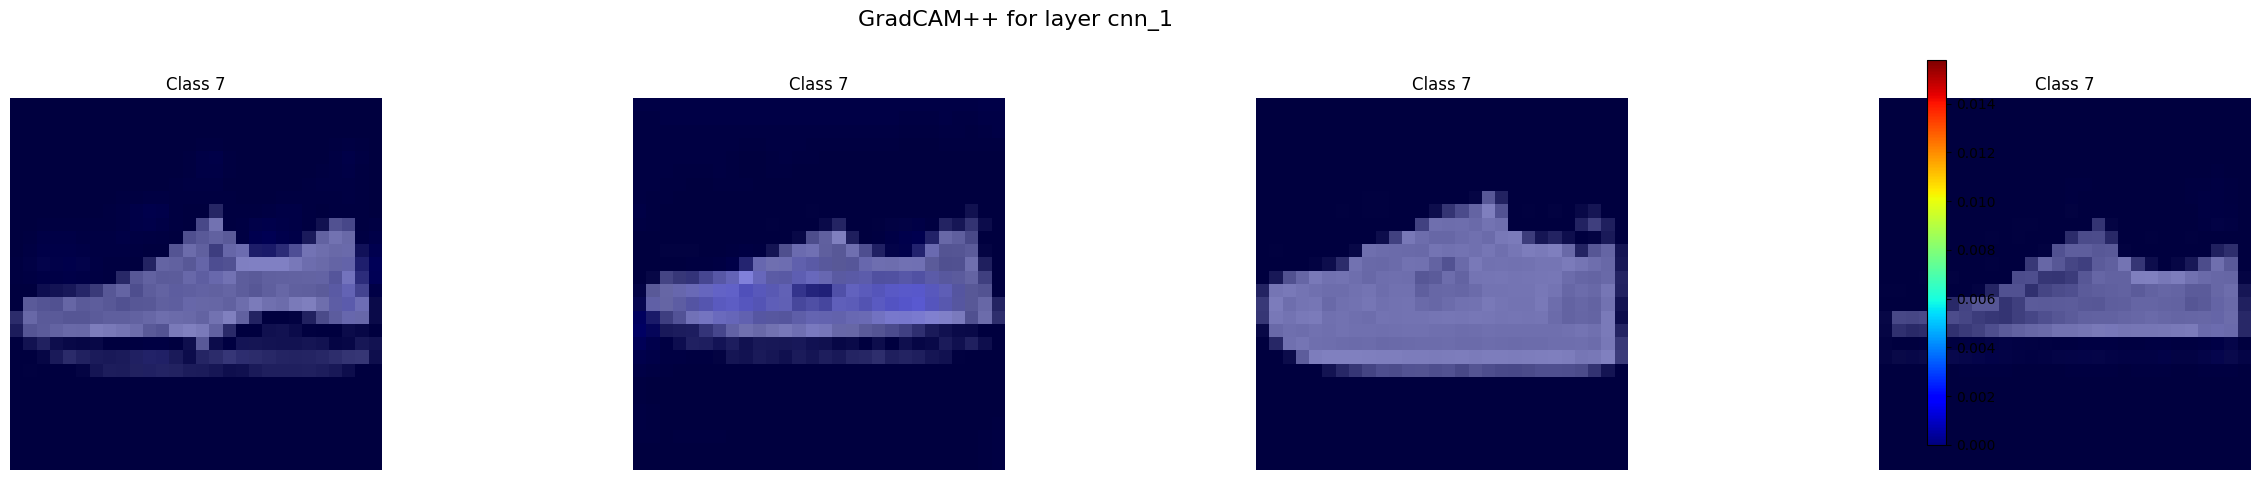

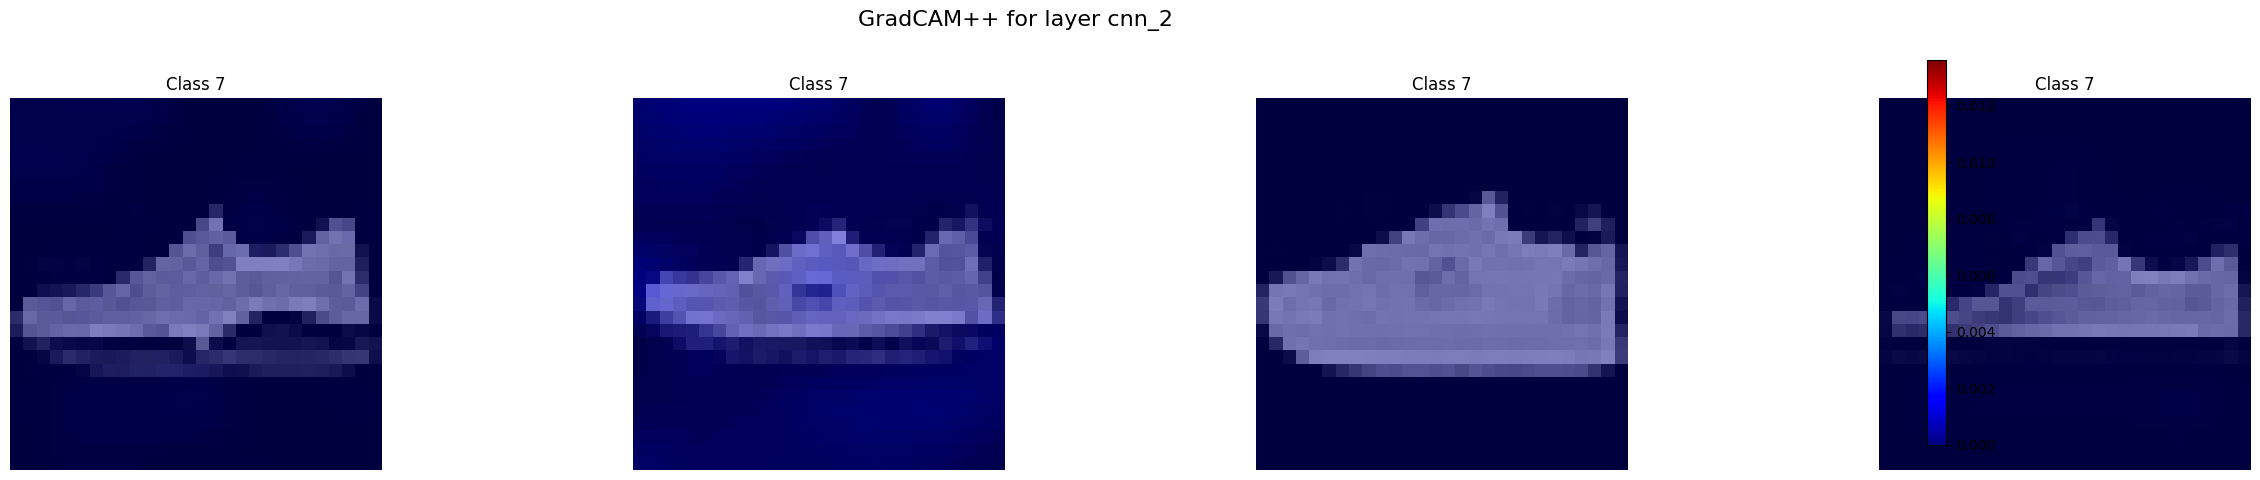

In [ ]:
# List of layers to visualize using GradCAM++
layers = ['cnn_0', 'cnn_1', 'cnn_2']

# Select the first 4 images from the test set
num_images = 4
class_label = 7
class_indices = np.where(y_test == class_label)[0]
random_indices = np.random.choice(class_indices, num_images, replace=False)
images = X_test[random_indices].reshape(-1, 28, 28, 1)
labels = y_test[random_indices]


# Visualize the original images
fig, axes = plt.subplots(1, num_images, figsize=(25, 5))
for ax_img, image, label in zip(axes, images, labels):
    ax_img.imshow(image.squeeze(), cmap='gray')
    ax_img.axis('off')
    ax_img.set_title(f'Original\nClass {label}')  # Replace 'label' with actual class label if available
plt.tight_layout()
plt.show()

# Create a model with the classifier output layer
model_for_gradcam = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('dense').output)

# Initialize GradCAM++ object
gradcam = GradcamPlusPlus(model_for_gradcam, model_modifier=ReplaceToLinear(), clone=True)

# Iterate over each layer for GradCAM++ visualization
for layer in layers:
    # Generate GradCAM++ heatmaps and visualize them
    fig, axes = plt.subplots(1, num_images, figsize=(25, 5))
    fig.suptitle(f'GradCAM++ for layer {layer}', fontsize=16)  # Add title with layer name

    for ax_heatmap, image, label in zip(axes, images, labels):
        # Generate the CAM using GradCAM++ for the specified layer
        cam = gradcam(CategoricalScore(1), image.reshape(1, 28, 28, 1), penultimate_layer=layer, normalize_cam=False)

        # Convert the CAM to a heatmap and plot it over the original image
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
        ax_heatmap.imshow(image.squeeze(), cmap='gray')
        ax_heatmap.imshow(heatmap, cmap='jet', alpha=0.5)
        ax_heatmap.axis('off')
        ax_heatmap.set_title(f'Class {label}')

    # Add a single color bar to the figure
    norm = plt.Normalize(vmin=cam[0].min(), vmax=cam[0].max())
    sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=axes, orientation="vertical", fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
